# Grow Op Farms Lab Selection Analysis -- **NOT FINISHED**

This notebook determines the lab Grow Op Farms should use to maximize THC results on thier products.

## Imports

In [1]:
%cd "~/code/dsi/capstone_1"

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm


sys.path.insert(0, '..')
from scripts.helper_functions import ecdf, bootstrap_confidence_interval, bootstrap

plt.style.use('ggplot')

lic_data = pd.read_csv('data/licensees_year_Nonemonth_None.csv/part-00000-e336c06b-db61-472c-8357-de32b6d8a4df-c000.csv')
lab_data = pd.read_csv('data/lab_results_all')

/home/austin/code/dsi/capstone_1


## Data Overview

This isn't our first pass on this data. It's already been cut up by our pyspark data pipeline. Here we take a further look at the enitre set of licensees and all the lab results that were created in 2020.  

In [2]:
lic_data.head()

,global_id,created_at,external_id,name,type
0,WAWA1.MM1,1900-01-01T00:00:00.000-08:00,1,WA State,state
1,WAWA1.MM2,1900-01-01T00:00:00.000-08:00,1111,LCB Grow,cultivator
2,WAWA1.MM3,1900-01-01T00:00:00.000-08:00,2222,LCB Mfg,production
3,WAWA1.MM4,1900-01-01T00:00:00.000-08:00,3333,LCB Retail,dispensary
4,WAWA1.MM5,1900-01-01T00:00:00.000-08:00,4444,LCB Lab,lab


In [3]:
lab_data.head()

,Unnamed: 0,global_id,created_at,mme_id,user_id,external_id,inventory_id,updated_at,status,testing_status,batch_id,for_mme_id,lab_user_id,type,cannabinoid_status,cannabinoid_editor,cannabinoid_d9_thc_percent,cannabinoid_cbd_percent,cannabinoid_cbda_percent
0,0,WAL20.LR13GJS,2020-01-01 05:33:50,WAWA1.MM1VC,WAWA1.US2VM,P191227-4 001,WAL20.INFMAK8,2020-01-01 05:33:51,passed,completed,WAL20.BAFRDM6,WAWA1.MMD8,WAWA1.US2VM,harvest_materials,completed,NaN,0.465,0.0,0.0
1,1,WAL20.LR13GJT,2020-01-01 05:33:51,WAWA1.MM1VC,WAWA1.US2VM,P191227-4 002,WAL20.INFMAK9,2020-01-01 05:33:51,passed,completed,WAL20.BAFRDM7,WAWA1.MMD8,WAWA1.US2VM,intermediate_product,completed,NaN,18.137,0.0,0.0
2,2,WAL20.LR13GJU,2020-01-01 05:33:51,WAWA1.MM1VC,WAWA1.US2VM,P191227-4 003,WAL20.INFMAKA,2020-01-01 05:33:51,passed,completed,WAL20.BAFRDM8,WAWA1.MMD8,WAWA1.US2VM,end_product,completed,NaN,0.102,0.0,0.0
3,3,WAL3.LR13GJV,2020-01-01 22:13:10,WAWA1.MM1L2,WAWA1.US2IP,NaN,WAL3.INFPXAD,2020-01-03 09:28:50,failed,in_progress,WAL3.BAFUARZ,WAWA1.MMX7,WAWA1.US2IP,marijuana,NaN,NaN,NaN,NaN,NaN
4,4,WAL3.LR13GJW,2020-01-01 22:14:33,WAWA1.MM1L2,WAWA1.US2IP,NaN,WAL3.INFPXAN,2020-01-05 12:20:24,failed,in_progress,WAL3.BAFUASE,WAWA1.MMUT,WAWA1.US2IP,marijuana,NaN,NaN,NaN,NaN,NaN


We need to merge these to dataframes together so we can get the lab and requester names for each lab test. 

In [4]:
df = lab_data.merge(lic_data, how='left', left_on='mme_id', right_on='global_id') # 1st merge gets lab name

df = df.drop(columns=['cannabinoid_cbd_percent', 'user_id', 'inventory_id', 'external_id_x', 'global_id_y'
                      , 'updated_at', 'status', 'testing_status', 'cannabinoid_status', 'external_id_y'
                      , 'cannabinoid_editor', 'lab_user_id','cannabinoid_cbda_percent'])

df = df.merge(lic_data, how='left', left_on='for_mme_id', right_on='global_id') # 2nd merge gets requester's name

df = df.drop(columns=['global_id', 'created_at', 'external_id', 'created_at_x', 'created_at_y', 'global_id'])
df = df.iloc[: , 1:] # drops extra index

Let's rename a few of these columns to be more descriptive. 

In [5]:
df = df.rename(columns={'name_x': 'lab_name'
                   , 'type_y': 'lab_business_type'
                   , 'nameglobal_id': 'requester_name'
                   , 'type': 'requester_business_type'
                   , 'name_y': 'requester_name'
                   , 'type_x': 'material_type'
                   , 'global_id_x': 'test_id'})

Next lets check for nulls. 

In [6]:
df.isnull().sum() / len(df)

test_id                       0.00000
mme_id                        0.00000
batch_id                      0.00000
for_mme_id                    0.00000
material_type                 0.00000
cannabinoid_d9_thc_percent    0.06466
lab_name                      0.00000
lab_business_type             0.00000
requester_name                0.00000
requester_business_type       0.00000
dtype: float64

6.5% if our tests did not test for THC D9. This is shouldn't be conserning because not all requesters will want this test. We will drop all of these test's since they provide no insight to the THC levels of a product.

In [7]:
df.dropna(inplace=True) # this is okay since cannabinoid_d9_thc_percent is the only column with nulls.

In [8]:
df.tail()

,test_id,mme_id,batch_id,for_mme_id,material_type,cannabinoid_d9_thc_percent,lab_name,lab_business_type,requester_name,requester_business_type
141126,WAL22.LR16HFY,WAWA1.MM1LF,WAL22.BALUDBD,WAWA1.MME6,intermediate_product,2.75,CAPITOL ANALYSIS,lab,AGRO COUTURE,cultivator_production
141127,WAL22.LR16HFZ,WAWA1.MM1LF,WAL22.BALUFTG,WAWA1.MMV9,intermediate_product,77.92,CAPITOL ANALYSIS,lab,"CANNABIS NORTHWEST C-M, INC",production
141128,WAL22.LR16HG0,WAWA1.MM1LF,WAL22.BALUFTH,WAWA1.MMV9,intermediate_product,11.85,CAPITOL ANALYSIS,lab,"CANNABIS NORTHWEST C-M, INC",production
141129,WAL22.LR16HG1,WAWA1.MM1LF,WAL22.BALUFTF,WAWA1.MMV9,intermediate_product,1.86,CAPITOL ANALYSIS,lab,"CANNABIS NORTHWEST C-M, INC",production
141132,WAL22.LR16HG4,WAWA1.MM1LF,WAL22.BALUFTI,WAWA1.MMV9,intermediate_product,74.34,CAPITOL ANALYSIS,lab,"CANNABIS NORTHWEST C-M, INC",production


We will now confirm no nulls exist (all cols should have the same non-null value) and our data types are what we want them to be--the only one that really matters is cannabinoid_d9_thc_percent--and it should be a float.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132012 entries, 0 to 141132
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   test_id                     132012 non-null  object 
 1   mme_id                      132012 non-null  object 
 2   batch_id                    132012 non-null  object 
 3   for_mme_id                  132012 non-null  object 
 4   material_type               132012 non-null  object 
 5   cannabinoid_d9_thc_percent  132012 non-null  float64
 6   lab_name                    132012 non-null  object 
 7   lab_business_type           132012 non-null  object 
 8   requester_name              132012 non-null  object 
 9   requester_business_type     132012 non-null  object 
dtypes: float64(1), object(9)
memory usage: 11.1+ MB


The result is exactly what we were hoping for. Lets extract all the records for our target business--Grow Op Farms. 

In [53]:
df_by_requester = df.groupby('requester_name')
grow_op = df_by_requester.get_group('GROW OP FARMS')
grow_op = grow_op.copy() # avoid setting to a view warning
grow_op.head()

,test_id,mme_id,batch_id,for_mme_id,material_type,cannabinoid_d9_thc_percent,lab_name,lab_business_type,requester_name,requester_business_type
243,WAL12.LR13GQJ,WAWA1.MM1L9,WAL12.BAFT7WB,WAWA1.MM7A,harvest_materials,0.80,Green Grower Labs,lab,GROW OP FARMS,cultivator_production
246,WAL12.LR13GQM,WAWA1.MM1L9,WAL12.BAFT7WC,WAWA1.MM7A,harvest_materials,0.73,Green Grower Labs,lab,GROW OP FARMS,cultivator_production
248,WAL12.LR13GQO,WAWA1.MM1L9,WAL12.BAFT7WD,WAWA1.MM7A,harvest_materials,0.72,Green Grower Labs,lab,GROW OP FARMS,cultivator_production
249,WAL12.LR13GQP,WAWA1.MM1L9,WAL12.BAFT7WE,WAWA1.MM7A,harvest_materials,0.67,Green Grower Labs,lab,GROW OP FARMS,cultivator_production
250,WAL12.LR13GQQ,WAWA1.MM1L9,WAL12.BAFT7WF,WAWA1.MM7A,harvest_materials,0.61,Green Grower Labs,lab,GROW OP FARMS,cultivator_production


Let's plot the hist/KDE for cannabinoid_d9_thc_percent since it looks like our percentages may be in decimal form.

''

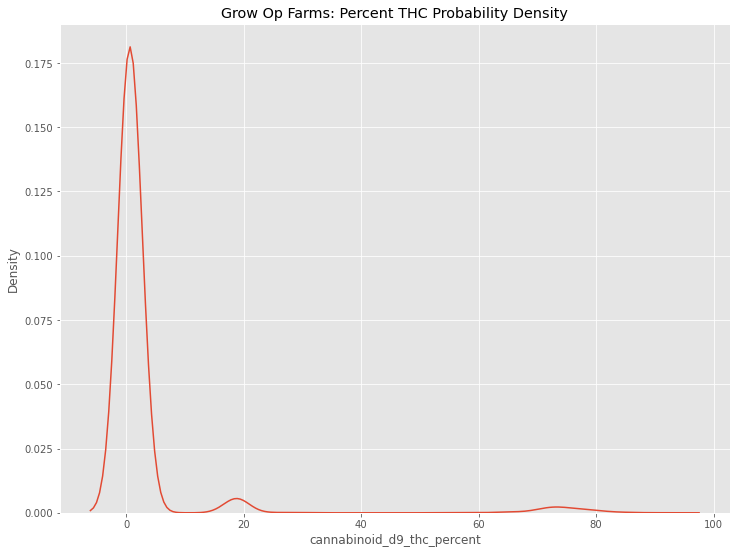

In [54]:
fig, ax = plt.subplots(figsize=(12,9))
sns.kdeplot(grow_op['cannabinoid_d9_thc_percent'], label='THC D9 %', ax=ax)
ax.set_title('Grow Op Farms: Percent THC Probability Density')
;

It is possible these tests are for goods that are bound for a state where THC is illegal and must conform to strict THC limits. However, if this is the case we should see a bimodal distribution due to the two different normal distributions being combined. Therefore, it is more likely these are just decimal form percentages. To fix this we will multiply all values below 1 by 100. While we are at it we will also drop values below 0 and above 100.

In [65]:
bins = []
for i, row in grow_op.iterrows():
    thc = row['cannabinoid_d9_thc_percent']
    if thc > 50:
        bin_ = 'high'
    elif .3 < thc <= 50:
        bin_ = 'med'
    else:
        bin_ = 'low'
    
    bins.append(bin_)
        
grow_op['thc_bin'] = bins

In [71]:
grow_op['cannabinoid_d9_thc_percent'] = [percent if percent > 1 else percent*100 for percent in grow_op['cannabinoid_d9_thc_percent'].values]
grow_op['cannabinoid_d9_thc_percent'] = grow_op['cannabinoid_d9_thc_percent'][(grow_op['cannabinoid_d9_thc_percent'] <= 100)
                                                                              & (grow_op['cannabinoid_d9_thc_percent'] >= 0)]

In [75]:
# we only want to look at products that are targeted to be higher THC.
data = grow_op['cannabinoid_d9_thc_percent'][grow_op['cannabinoid_d9_thc_percent'] > 20]

In [73]:
grow_op.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7080 entries, 243 to 140927
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   test_id                     7080 non-null   object 
 1   mme_id                      7080 non-null   object 
 2   batch_id                    7080 non-null   object 
 3   for_mme_id                  7080 non-null   object 
 4   material_type               7080 non-null   object 
 5   cannabinoid_d9_thc_percent  7080 non-null   float64
 6   lab_name                    7080 non-null   object 
 7   lab_business_type           7080 non-null   object 
 8   requester_name              7080 non-null   object 
 9   requester_business_type     7080 non-null   object 
 10  thc_bin                     7080 non-null   object 
dtypes: float64(1), object(10)
memory usage: 663.8+ KB


''

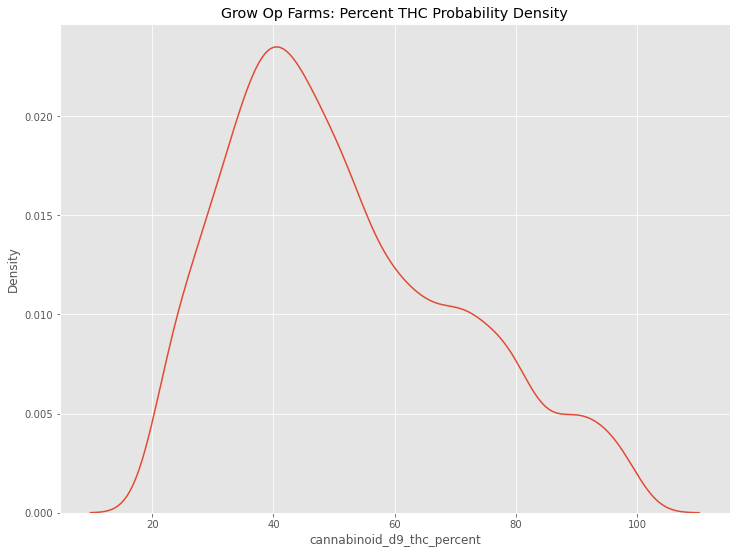

In [76]:
fig, ax = plt.subplots(figsize=(12,9))
sns.kdeplot(data, label='THC D9 %', ax=ax)
ax.set_title('Grow Op Farms: Percent THC Probability Density')
;

That appears to have fixed our decimal problem. Lets continue and look at the labs Grow Op Farms' uses and type of materials they get tested. 

In [16]:
grow_op['lab_name'].value_counts()

Green Grower Labs       4181
Praxis Laboratory       2896
Testing Technologies       3
Name: lab_name, dtype: int64

In [17]:
grow_op['material_type'].value_counts()

harvest_materials       6634
end_product              216
intermediate_product     198
marijuana                 32
Name: material_type, dtype: int64

Grow Op Farms appears to mainly test harvert materials and uses two labs to conduct those tests. Lets filter down by material type to only include harvest materials and group by labs. This should be our final dataset to begin testing with.

In [18]:
grow_op_harvest = grow_op[grow_op['material_type'] == 'harvest_materials'].copy()
grow_op_by_lab = grow_op_harvest.groupby('lab_name')
grow_op_by_lab.head()

,test_id,mme_id,batch_id,for_mme_id,material_type,cannabinoid_d9_thc_percent,lab_name,lab_business_type,requester_name,requester_business_type
243,WAL12.LR13GQJ,WAWA1.MM1L9,WAL12.BAFT7WB,WAWA1.MM7A,harvest_materials,80.000,Green Grower Labs,lab,GROW OP FARMS,cultivator_production
246,WAL12.LR13GQM,WAWA1.MM1L9,WAL12.BAFT7WC,WAWA1.MM7A,harvest_materials,73.000,Green Grower Labs,lab,GROW OP FARMS,cultivator_production
248,WAL12.LR13GQO,WAWA1.MM1L9,WAL12.BAFT7WD,WAWA1.MM7A,harvest_materials,72.000,Green Grower Labs,lab,GROW OP FARMS,cultivator_production
249,WAL12.LR13GQP,WAWA1.MM1L9,WAL12.BAFT7WE,WAWA1.MM7A,harvest_materials,67.000,Green Grower Labs,lab,GROW OP FARMS,cultivator_production
250,WAL12.LR13GQQ,WAWA1.MM1L9,WAL12.BAFT7WF,WAWA1.MM7A,harvest_materials,61.000,Green Grower Labs,lab,GROW OP FARMS,cultivator_production
404,WAL20.LR13GV0,WAWA1.MM1VC,WAL20.BAFTHB3,WAWA1.MM7A,harvest_materials,2.465,Praxis Laboratory,lab,GROW OP FARMS,cultivator_production
405,WAL20.LR13GV1,WAWA1.MM1VC,WAL20.BAFTHB4,WAWA1.MM7A,harvest_materials,2.579,Praxis Laboratory,lab,GROW OP FARMS,cultivator_production
406,WAL20.LR13GV2,WAWA1.MM1VC,WAL20.BAFTHB6,WAWA1.MM7A,harvest_materials,2.317,Praxis Laboratory,lab,GROW OP FARMS,cultivator_production
407,WAL20.LR13GV3,WAWA1.MM1VC,WAL20.BAFTHB7,WAWA1.MM7A,harvest_materials,2.718,Praxis Laboratory,lab,GROW OP FARMS,cultivator_production
408,WAL20.LR13GV4,WAWA1.MM1VC,WAL20.BAFTHB8,WAWA1.MM7A,harvest_materials,2.273,Praxis Laboratory,lab,GROW OP FARMS,cultivator_production
